# TinyMS LeNet5 教程

在本教程中，我们会演示使用TinyMS API构建LeNet5模型，下载数据集，训练，启动服务器和推理的过程。

## 环境要求
 - Ubuntu: `18.04`
 - Python: `3.7.x`
 - Flask: `1.1.2`
 - MindSpore: `CPU-1.1.1`
 - TinyMS: `0.1.0`
 - numpy: `1.17.5`
 - opencv-python: `4.5.1.48`
 - Pillow: `8.1.0`
 - pip: `21.0.1`
 - requests: `2.18.4`
 
## 介绍

TinyMS是一个高级API，目的是让新手用户能够更加轻松地上手深度学习。TinyMS可以有效地减少用户在构建、训练、验证和推理一个模型过程中的操作次数。TinyMS也提供了教程和文档帮助开发者更好的上手和开发。

本教程包括6部分，`构建模型`、`下载数据集`、`训练`，`定义servable json`, `启动服务器`和`推理`，其中服务器将在一个子进程中启动。

In [1]:
import os
import json
import tinyms as ts
import tinyms.optimizers as opt

from PIL import Image
from tinyms import context
from tinyms.data import MnistDataset, download_dataset
from tinyms.vision import mnist_transform
from tinyms.model import Model, lenet5
from tinyms.serving import start_server, predict, list_servables, shutdown, server_started
from tinyms.metrics import Accuracy
from tinyms.losses import SoftmaxCrossEntropyWithLogits
from tinyms.callbacks import ModelCheckpoint, CheckpointConfig, LossMonitor

[WARNING] ME(20419:139790455768896,MainProcess):2021-03-17-16:30:19.184.319 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


### 1. 构建模型

TinyMS封装了MindSpore LeNet5模型中的init和construct函数，代码行数能够大大减少，原有的大量代码段行数会被极限压缩:

In [2]:
# 构建网络
net = lenet5(class_num=10)
model = Model(net)

### 2. 下载数据集

如果根目录下没有创建`mnist`文件夹则MNIST数据集会被自动下载并存放到根目录，如果`mnist`文件夹已经存在于根目录 ，则此步操作会被跳过

In [3]:
# 下载数据集
mnist_path = '/root/mnist'
if not os.path.exists(mnist_path):
    ts.data.download_dataset('mnist', '/root')
    print('************Download complete*************')
else:
    print('************Dataset already exists.**************')

************Dataset already exists.**************


### 3. 训练模型

数据集中的训练集、验证集都会在此步骤中定义，同时也会定义训练参数。训练后生成的ckpt文件会保存到`/etc/tinyms/serving/lenet5`文件夹以便后续使用，训练完成后会进行验证并输出 `Accuracy`指标。

In [4]:
# 创建mnist路径
ckpt_folder = '/etc/tinyms/serving/lenet5'
ckpt_path = '/etc/tinyms/serving/lenet5/lenet5.ckpt'
if not os.path.exists(ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/lenet5
else:
    print('lenet5 ckpt folder already exists')

# 设置环境参数
device_target = "CPU"
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)  
dataset_sink_mode = False

# 创建数据集
train_dataset = MnistDataset(os.path.join(mnist_path, "train"), shuffle=True)
train_dataset = mnist_transform.apply_ds(train_dataset)
eval_dataset = MnistDataset(os.path.join(mnist_path, "test"), shuffle=True)
eval_dataset = mnist_transform.apply_ds(eval_dataset)

# 设置训练参数
lr = 0.01
momentum = 0.9
epoch_size = 1
batch_size = 32

# 定义loss函数
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义optimizer
net_opt = opt.Momentum(net.trainable_params(), lr, momentum)
net_metrics={"Accuracy": Accuracy()}
model.compile(loss_fn=net_loss, optimizer=net_opt, metrics=net_metrics)

print('************************Start training*************************')
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10))
model.train(epoch_size, train_dataset, callbacks=[ckpoint_cb, LossMonitor()],dataset_sink_mode=dataset_sink_mode)
print('************************Finished training*************************')
model.save_checkpoint(ckpt_path)


model.load_checkpoint(ckpt_path)
print('************************Start evaluation*************************')
acc = model.eval(eval_dataset, dataset_sink_mode=dataset_sink_mode)
print("============== Accuracy:{} ==============".format(acc))

lenet5 ckpt folder already exists
************************Start training*************************
epoch: 1 step: 1, loss is 2.3025777
epoch: 1 step: 2, loss is 2.3023536
epoch: 1 step: 3, loss is 2.3025866
epoch: 1 step: 4, loss is 2.3026567
epoch: 1 step: 5, loss is 2.3029456
epoch: 1 step: 6, loss is 2.3029842
epoch: 1 step: 7, loss is 2.3041089
epoch: 1 step: 8, loss is 2.3036628
epoch: 1 step: 9, loss is 2.3030944
epoch: 1 step: 10, loss is 2.3029993
epoch: 1 step: 11, loss is 2.302108
epoch: 1 step: 12, loss is 2.3020008
epoch: 1 step: 13, loss is 2.304099
epoch: 1 step: 14, loss is 2.301239
epoch: 1 step: 15, loss is 2.3052783
epoch: 1 step: 16, loss is 2.3051472
epoch: 1 step: 17, loss is 2.301609
epoch: 1 step: 18, loss is 2.304048
epoch: 1 step: 19, loss is 2.3017287
epoch: 1 step: 20, loss is 2.3040388
epoch: 1 step: 21, loss is 2.3002918
epoch: 1 step: 22, loss is 2.2996142
epoch: 1 step: 23, loss is 2.3003268
epoch: 1 step: 24, loss is 2.3015232
epoch: 1 step: 25, loss is 2

epoch: 1 step: 219, loss is 2.2939663
epoch: 1 step: 220, loss is 2.2928524
epoch: 1 step: 221, loss is 2.3152244
epoch: 1 step: 222, loss is 2.3061361
epoch: 1 step: 223, loss is 2.279769
epoch: 1 step: 224, loss is 2.3070345
epoch: 1 step: 225, loss is 2.300171
epoch: 1 step: 226, loss is 2.310479
epoch: 1 step: 227, loss is 2.3122015
epoch: 1 step: 228, loss is 2.304152
epoch: 1 step: 229, loss is 2.302532
epoch: 1 step: 230, loss is 2.2945035
epoch: 1 step: 231, loss is 2.3043995
epoch: 1 step: 232, loss is 2.3016453
epoch: 1 step: 233, loss is 2.2991867
epoch: 1 step: 234, loss is 2.3200743
epoch: 1 step: 235, loss is 2.3098545
epoch: 1 step: 236, loss is 2.2987309
epoch: 1 step: 237, loss is 2.3038387
epoch: 1 step: 238, loss is 2.3094444
epoch: 1 step: 239, loss is 2.300459
epoch: 1 step: 240, loss is 2.3098435
epoch: 1 step: 241, loss is 2.3092139
epoch: 1 step: 242, loss is 2.3189032
epoch: 1 step: 243, loss is 2.3043907
epoch: 1 step: 244, loss is 2.3151603
epoch: 1 step: 245

epoch: 1 step: 437, loss is 2.3037019
epoch: 1 step: 438, loss is 2.2810555
epoch: 1 step: 439, loss is 2.3046095
epoch: 1 step: 440, loss is 2.3064158
epoch: 1 step: 441, loss is 2.3039155
epoch: 1 step: 442, loss is 2.2979496
epoch: 1 step: 443, loss is 2.2950149
epoch: 1 step: 444, loss is 2.3039205
epoch: 1 step: 445, loss is 2.313383
epoch: 1 step: 446, loss is 2.2997854
epoch: 1 step: 447, loss is 2.3025367
epoch: 1 step: 448, loss is 2.3072577
epoch: 1 step: 449, loss is 2.2864583
epoch: 1 step: 450, loss is 2.2989352
epoch: 1 step: 451, loss is 2.2963326
epoch: 1 step: 452, loss is 2.2991695
epoch: 1 step: 453, loss is 2.2902248
epoch: 1 step: 454, loss is 2.2939851
epoch: 1 step: 455, loss is 2.2982528
epoch: 1 step: 456, loss is 2.3092663
epoch: 1 step: 457, loss is 2.3012593
epoch: 1 step: 458, loss is 2.3137474
epoch: 1 step: 459, loss is 2.2921197
epoch: 1 step: 460, loss is 2.3031266
epoch: 1 step: 461, loss is 2.3182535
epoch: 1 step: 462, loss is 2.281737
epoch: 1 step:

epoch: 1 step: 654, loss is 0.8525744
epoch: 1 step: 655, loss is 0.6584808
epoch: 1 step: 656, loss is 0.7571933
epoch: 1 step: 657, loss is 0.9151435
epoch: 1 step: 658, loss is 0.64045644
epoch: 1 step: 659, loss is 0.68640834
epoch: 1 step: 660, loss is 0.8460708
epoch: 1 step: 661, loss is 0.6060891
epoch: 1 step: 662, loss is 0.55792475
epoch: 1 step: 663, loss is 0.63292235
epoch: 1 step: 664, loss is 0.5693629
epoch: 1 step: 665, loss is 0.62148523
epoch: 1 step: 666, loss is 1.056205
epoch: 1 step: 667, loss is 1.0021751
epoch: 1 step: 668, loss is 0.41490448
epoch: 1 step: 669, loss is 0.7679162
epoch: 1 step: 670, loss is 0.76246095
epoch: 1 step: 671, loss is 0.84235364
epoch: 1 step: 672, loss is 0.787255
epoch: 1 step: 673, loss is 0.5855223
epoch: 1 step: 674, loss is 0.55998546
epoch: 1 step: 675, loss is 0.53138906
epoch: 1 step: 676, loss is 0.70548004
epoch: 1 step: 677, loss is 0.43360138
epoch: 1 step: 678, loss is 0.68392205
epoch: 1 step: 679, loss is 0.44937983


epoch: 1 step: 867, loss is 0.13261117
epoch: 1 step: 868, loss is 0.33647352
epoch: 1 step: 869, loss is 0.15571825
epoch: 1 step: 870, loss is 0.11454045
epoch: 1 step: 871, loss is 0.16231136
epoch: 1 step: 872, loss is 0.14572567
epoch: 1 step: 873, loss is 0.15818222
epoch: 1 step: 874, loss is 0.19414617
epoch: 1 step: 875, loss is 0.057220258
epoch: 1 step: 876, loss is 0.5399907
epoch: 1 step: 877, loss is 0.50323814
epoch: 1 step: 878, loss is 0.16099009
epoch: 1 step: 879, loss is 0.15590623
epoch: 1 step: 880, loss is 0.36842492
epoch: 1 step: 881, loss is 0.4031075
epoch: 1 step: 882, loss is 0.28387004
epoch: 1 step: 883, loss is 0.36674473
epoch: 1 step: 884, loss is 0.27427325
epoch: 1 step: 885, loss is 0.29653215
epoch: 1 step: 886, loss is 0.405498
epoch: 1 step: 887, loss is 0.51243156
epoch: 1 step: 888, loss is 0.1636527
epoch: 1 step: 889, loss is 0.32325193
epoch: 1 step: 890, loss is 0.38569173
epoch: 1 step: 891, loss is 0.33114237
epoch: 1 step: 892, loss is 0

epoch: 1 step: 1076, loss is 0.13103503
epoch: 1 step: 1077, loss is 0.52587456
epoch: 1 step: 1078, loss is 0.10299886
epoch: 1 step: 1079, loss is 0.066845395
epoch: 1 step: 1080, loss is 0.11382544
epoch: 1 step: 1081, loss is 0.2933532
epoch: 1 step: 1082, loss is 0.062687084
epoch: 1 step: 1083, loss is 0.6439765
epoch: 1 step: 1084, loss is 0.46292502
epoch: 1 step: 1085, loss is 0.0806005
epoch: 1 step: 1086, loss is 0.3541138
epoch: 1 step: 1087, loss is 0.1060416
epoch: 1 step: 1088, loss is 0.11656676
epoch: 1 step: 1089, loss is 0.08570526
epoch: 1 step: 1090, loss is 0.30926794
epoch: 1 step: 1091, loss is 0.06504152
epoch: 1 step: 1092, loss is 0.1294982
epoch: 1 step: 1093, loss is 0.06666623
epoch: 1 step: 1094, loss is 0.08977629
epoch: 1 step: 1095, loss is 0.012176578
epoch: 1 step: 1096, loss is 0.045609307
epoch: 1 step: 1097, loss is 0.27441457
epoch: 1 step: 1098, loss is 0.08697969
epoch: 1 step: 1099, loss is 0.12002273
epoch: 1 step: 1100, loss is 0.10471344
ep

epoch: 1 step: 1281, loss is 0.030004023
epoch: 1 step: 1282, loss is 0.07597791
epoch: 1 step: 1283, loss is 0.073831655
epoch: 1 step: 1284, loss is 0.29810286
epoch: 1 step: 1285, loss is 0.1132233
epoch: 1 step: 1286, loss is 0.07252343
epoch: 1 step: 1287, loss is 0.012536226
epoch: 1 step: 1288, loss is 0.21477328
epoch: 1 step: 1289, loss is 0.08646393
epoch: 1 step: 1290, loss is 0.21891351
epoch: 1 step: 1291, loss is 0.028665408
epoch: 1 step: 1292, loss is 0.13709432
epoch: 1 step: 1293, loss is 0.017844783
epoch: 1 step: 1294, loss is 0.12268145
epoch: 1 step: 1295, loss is 0.11659356
epoch: 1 step: 1296, loss is 0.15494885
epoch: 1 step: 1297, loss is 0.122669786
epoch: 1 step: 1298, loss is 0.01046409
epoch: 1 step: 1299, loss is 0.056485437
epoch: 1 step: 1300, loss is 0.2121078
epoch: 1 step: 1301, loss is 0.10384044
epoch: 1 step: 1302, loss is 0.029057024
epoch: 1 step: 1303, loss is 0.11940734
epoch: 1 step: 1304, loss is 0.13816424
epoch: 1 step: 1305, loss is 0.088

epoch: 1 step: 1486, loss is 0.06912272
epoch: 1 step: 1487, loss is 0.07840847
epoch: 1 step: 1488, loss is 0.14771412
epoch: 1 step: 1489, loss is 0.1400881
epoch: 1 step: 1490, loss is 0.17096727
epoch: 1 step: 1491, loss is 0.16490632
epoch: 1 step: 1492, loss is 0.17573768
epoch: 1 step: 1493, loss is 0.13727075
epoch: 1 step: 1494, loss is 0.021594124
epoch: 1 step: 1495, loss is 0.2077843
epoch: 1 step: 1496, loss is 0.15017173
epoch: 1 step: 1497, loss is 0.088545844
epoch: 1 step: 1498, loss is 0.085715264
epoch: 1 step: 1499, loss is 0.21272267
epoch: 1 step: 1500, loss is 0.1819271
epoch: 1 step: 1501, loss is 0.021068264
epoch: 1 step: 1502, loss is 0.04373883
epoch: 1 step: 1503, loss is 0.0073648244
epoch: 1 step: 1504, loss is 0.0132490145
epoch: 1 step: 1505, loss is 0.33317026
epoch: 1 step: 1506, loss is 0.1650341
epoch: 1 step: 1507, loss is 0.05693629
epoch: 1 step: 1508, loss is 0.29916528
epoch: 1 step: 1509, loss is 0.1890237
epoch: 1 step: 1510, loss is 0.196906

epoch: 1 step: 1691, loss is 0.31586635
epoch: 1 step: 1692, loss is 0.016652398
epoch: 1 step: 1693, loss is 0.30536532
epoch: 1 step: 1694, loss is 0.1146685
epoch: 1 step: 1695, loss is 0.18415359
epoch: 1 step: 1696, loss is 0.104863755
epoch: 1 step: 1697, loss is 0.06876555
epoch: 1 step: 1698, loss is 0.2796171
epoch: 1 step: 1699, loss is 0.060556445
epoch: 1 step: 1700, loss is 0.27135572
epoch: 1 step: 1701, loss is 0.17843182
epoch: 1 step: 1702, loss is 0.02482147
epoch: 1 step: 1703, loss is 0.021130752
epoch: 1 step: 1704, loss is 0.11698529
epoch: 1 step: 1705, loss is 0.13115078
epoch: 1 step: 1706, loss is 0.020555038
epoch: 1 step: 1707, loss is 0.14393555
epoch: 1 step: 1708, loss is 0.14842501
epoch: 1 step: 1709, loss is 0.46632153
epoch: 1 step: 1710, loss is 0.18283802
epoch: 1 step: 1711, loss is 0.1317218
epoch: 1 step: 1712, loss is 0.25727025
epoch: 1 step: 1713, loss is 0.06488792
epoch: 1 step: 1714, loss is 0.18351129
epoch: 1 step: 1715, loss is 0.0701038

### 4. 定义servable.json

定义lenet5 servable json文件，Servable json文件定义了servable名称，模型名称，模型格式和分类数量，以便后续推理使用

In [5]:
servable_json = [{'name': 'lenet5', 
                  'description': 'This servable hosts a lenet5 model predicting numbers', 
                  'model': {
                      "name": "lenet5", 
                      "format": "ckpt", 
                      "class_num": 10}}]
os.chdir("/etc/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

### 5. 启动服务器

#### 5.1 介绍
TinyMS推理是C/S（Client/Server）架构。TinyMS使用[Flask](https://flask.palletsprojects.com/en/1.1.x/)这个轻量化的网页服务器架构作为C/S通讯的基础架构。为了能够对模型进行推理，用户必须首先启动服务器。如果成功启动，服务器会在子进程中运行并且会监听从地址127.0.0.1，端口号5000发送来的POST请求并且使用MindSpore作为后端来处理这些请求。后端会构建模型，运行推理并且返回结果给客户端

#### 5.2 启动服务器

运行下列代码以启动服务器：

In [6]:
start_server()

Server starts at host 127.0.0.1, port 5000


### 6. 推理

#### 6.1 上传图片

用户需要上传一张0~9之间的数字图片作为输入。如果使用命令行终端，可以使用'scp'或者'wget'获取图片，如果使用Jupyter，点击菜单右上方的'Upload'按钮并且选择上传的图片。本教程中使用的图片可以点击[这里](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png)进行下载，将图片保存在根目录下，重命名为'7.png'（或者任何用户喜欢的名字）

或者运行如下的代码下载图片：

In [7]:
if not os.path.exists('/root/7.png'):
    !wget -P /root/ https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png
else:
    print('7.png already exists')

--2021-03-17 16:32:24--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.5, 49.4.112.113, 121.36.121.44, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34970 (34K) [image/png]
Saving to: ‘/root/7.png’

7.png               100%[===================>]  34.15K  --.-KB/s    in 0.1s    

2021-03-17 16:32:25 (323 KB/s) - ‘/root/7.png’ saved [34970/34970]



#### 6.2 List servables

使用`list_servables`函数检查当前后端的serving模型

In [8]:
list_servables()

[{'description': 'This servable hosts a lenet5 model predicting numbers',
  'model': {'class_num': 10, 'format': 'ckpt', 'name': 'lenet5'},
  'name': 'lenet5'}]

如果输出的`description`字段显示这是一个`lenet5`的模型，则可以继续到下一步发送推理请求

#### 6.3 发送推理请求

运行`predict`函数发送推理请求，第4个参数选择`TOP1_CLASS`或者`TOP5_CLASS`输出:

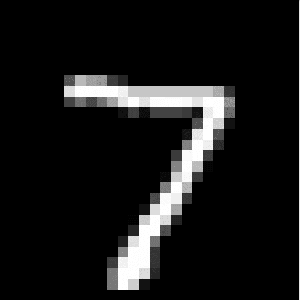

TOP1: 7, score: 0.99136555194854736328


In [9]:
# 设置图片路径和输出策略（可以在TOP1和TOP5中选择）
image_path = "/root/7.png"
strategy = "TOP1_CLASS"

# predict(image_path, servable_name, dataset='mnist', strategy='TOP1_CLASS')
# predict方法的四个参数分别是图片路径、servable名称，数据集名称（默认MNIST）和输出策略（默认输出TOP1，可以选择TOP5）
if server_started() is True:
    display(Image.open(image_path).resize((300, 300), Image.ANTIALIAS))
    print(predict(image_path,'lenet5', 'mnist', strategy))
else:
    print("Server not started")

如果用户能看到类似如下输出:  
```
TOP1: 7, score: 0.99934917688369750977
```  
那么意味着已经进行了一次成功的推理

## 关闭服务器

运行以下代码关闭服务器：

In [10]:
shutdown()

'Server shutting down...'